Please submit this file only, with all results on it. Do not print intermeidia results, like print(image)!

Name: Artur Sak

NetID:(sak2)

In [108]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import wavfile

%matplotlib inline

In [109]:
import math
from scipy.fftpack import dct

# Short Time Fourier Transform. Overlap 50%

1. Write a function that will compute a STFT of a single channel of audio. The spectrogram numpy array is already preallocated for you. 
2. Read in a portion of the audio files provided, plot your results using the provided `plotSTFT()` function. (If you did this part correctly, you should be getting a plot very similar to what you obtain from `specgram()` of last week's lab

In [110]:
def stft(x, N = 256, M = 128):
    ## this function should take in a signal x, 
    ## and compute a N-point STFT with step size M
    ## with a Hamming window applied to it

    n = len(x) # total length of the signal x
    K = (n-N)/M + 1 # number of  frames. The step between frames is M. 
    N2 = N/2  # keep only the positive frequencies. 
    S = np.zeros([N2+1,K+1]) # spectrogram of N2 + 1 frequencies and K + 1 time indices
    
    n_samples = M * K + N
    x_zero = np.zeros(n_samples)
    x_zero[0:n] = x
    
    for i in range(0,K + 1):
        S[:,i] = np.square(np.absolute(np.fft.fft(x_zero[i*(M):((i+1)*(M)) + 1] * np.hamming(M + 1))))
    return S

In [111]:
def plotSTFT(S):
    N = S.shape[0] # number of frequencies points
    tt = np.arange(S.shape[1]) # number of time indices
    freq = np.hstack([np.arange(0., N)/N, 1]) # frequency axis
    plt.pcolormesh(tt, freq, 10 * np.log10(S[:,:-1]+ 0.001), cmap = 'jet')  # plot your spectrogram
    plt.axis('tight')
    plt.ylabel('frequency (normalized)')
    plt.xlabel('time (in samples)')

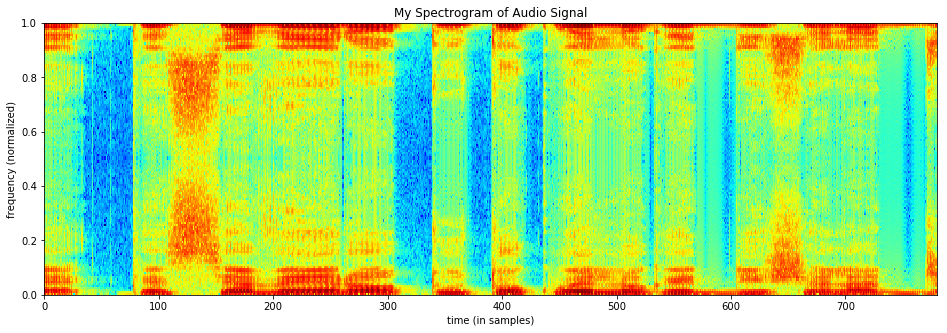

In [112]:
Fs, s = wavfile.read('data/italian.wav')

chunk_audio = s[100000:200000]
S = stft(chunk_audio)

plt.figure(figsize = (16, 5))
plotSTFT(S) 
plt.title('My Spectrogram of Audio Signal')

# Mel Frequency Cepstrum

The Mel Frequency Ceptrum is a human auditory response insipred audio feature that is being used succesfully in many audio processing applications. The Mel Frequency Cepstral Coefficients ([MFCC](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/)) are computed as follows:

1. Compute the Fourier Transform of the signal
2. Map power spectrum to the mel scale, using overlapping triangular windows (filter banks). 
3. Take log of the power spectrum in the mel 'frequency'
4. Compute the Discrete Cosine Transform of the spectrum computed above, as though it were a signal

The amplitudes obtained are the MFCC. A block diagram of the process is shown here:
![](MFCC.png)

We will implement each components below.

## A.  Converting from frequency to mel frequency and vice versa

First, two important formulas:

Formula to convert frequency $f$ Hertz to $m$ Mel:

$$m = 2595 * log_{10}(1+\frac{f}{700})$$

### Exercise 1

1. Derive the formula to convert from Mel back to Hertz
2. Implement these 2 conversions as functions

$$m = 2595 * log_{10}(1+\frac{f}{700})$$

$$f =700 * 10^{\frac{m}{2595}}-1$$

### Hint: 

see [this](http://stackoverflow.com/questions/13208286/how-to-write-latex-in-ipython-notebook) on how to write equations in the notebook and [this](https://wch.github.io/latexsheet/) for Latex cheat sheet. 

In [113]:
def hz2mel(h):
    ## This function should output the Mel-frequency given some input frequency
    ## h is a 1-d array of input frequencies in hertz, 
    
    h2m = lambda f: 2595. * np.log10(1 + (f/700.))
    mapper = np.vectorize(h2m)
    h = mapper(h)
    return h

def mel2hz(m):
    ## This function should output the frequency in Hertz given some input frequency
    ## m is a 1-d array of input frequencies in Mel,
    
    m2h = lambda x: 700. * (10.**(x/2595.) - 1.)
    mapper = np.vectorize(m2h)
    m = mapper(m)
    return m

## B. Mel-spaced filter banks

The Mel-spaced filterbank is the set of triangular window filter which corresponds to [human hearing perception](https://en.wikipedia.org/wiki/Mel_scale).
![](melfilterbank.jpg)
The following code is to use to generate **nfilt** filters using the end points supplied by binPoints vector. 

In [114]:
#filter bank generation
def filterBank(nfilt, NFFT, binPoints):
    fbank = np.zeros([nfilt,NFFT/2+1])
    for j in xrange(0,nfilt):
        for i in xrange(int(binPoints[j]),int(binPoints[j+1])):
            fbank[j,i] = (i - binPoints[j])/(binPoints[j+1]-binPoints[j]) #rising edge of the triangle
        for i in xrange(int(binPoints[j+1]),int(binPoints[j+2])):
            fbank[j,i] = (binPoints[j+2]-i)/(binPoints[j+2]-binPoints[j+1]) #falling edge of the triangle
    return fbank

Let's now look at how the Mel-spaced filter banks are applied to the power spectrum of an audio signal. The following code generates the filter banks given the sampling frequency, number of filters, and length of the FFT. (You will need to finish the code for previous section for this part to run)

In [115]:
Fs, x = wavfile.read('data/WakeMeUp.wav')     # x stores the input audio signal, Fs is the sampling frequency
signal = x[:,0]

highfreq = Fs/2       # Nyquist rate
lowfreq = 0           # lower end of audio spectrum

lowmel = hz2mel(lowfreq)     # convert to Mel scales
highmel = hz2mel(highfreq)

NFFT = 512            # number of FFT points
nfilt = 20            # number of Mel spaced filter banks

# convert the frequency into Mel points
melPoints = np.linspace(lowmel, highmel, nfilt + 2) # linear in Mel scale correspondings to human perception of sound
binPoints = np.floor(mel2hz(melPoints)/Fs*(NFFT+1)) # convert back to Hert 

fbank = filterBank(nfilt, NFFT, binPoints)

### Question 1: Why do we need nfilt + 2 points for the melPoints array?

Here's a visualization of the 20 filter banks in the frequency domain

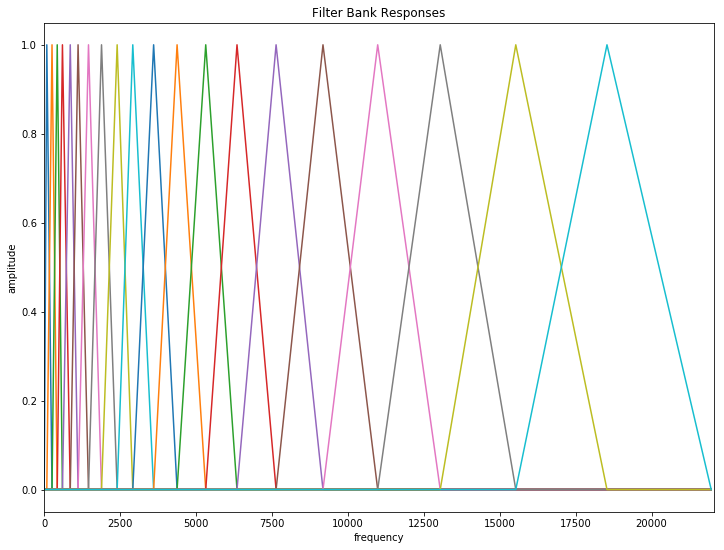

In [116]:
freq = np.arange(257)*(Fs/2.)/257    # generate frequencies for plot
plt.figure(figsize = (12, 9)) # make a bigger figure
for i in np.arange(nfilt):
    plt.plot(freq, fbank[i,:]) # plot 20 filter banks
plt.title('Filter Bank Responses')
ax = plt.axes()
ax.set_xlabel('frequency')
ax.set_ylabel('amplitude')
ax.set_xlim([0, 22050]);

### Question 2: looking at the filter bank, are human hearing sensitive to low or high frequencies?

Here we plot the power spectrum of a window of the audio signal. The plot is of what would be one column of the spectrogram as created in the previous lab.

(0, 22050)

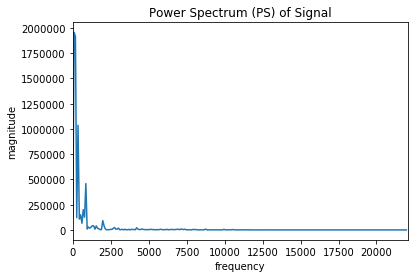

In [117]:
T = 10000 # 10000 samples
s = signal[T:T+NFFT]
f =  np.square((1.0/NFFT) *np.absolute(np.fft.rfft(s,)))

plt.figure()
plt.plot(freq, f)
plt.title('Power Spectrum (PS) of Signal')
ax = plt.axes()
ax.set_xlabel('frequency')
ax.set_ylabel('magnitude')
ax.set_xlim([0, 22050])

## C.  Filter bank coefficients

Finally, we see the result of applying the 12th filter bank to the window of the audio signal. To apply the filter, the filter and the power spectrum of the signal are simply multiplied together. The plot below is the product of the filter and the PS of the window.

(0, 22050)

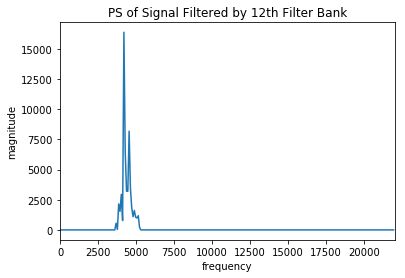

In [118]:
filtered_f = fbank*np.tile(f, (nfilt, 1))

plt.figure()
plt.plot(freq, filtered_f[11,:])
plt.title('PS of Signal Filtered by 12th Filter Bank')
ax = plt.axes()
ax.set_xlabel('frequency')
ax.set_ylabel('magnitude')
ax.set_xlim([0, 22050])

### Exercise 2: Plot the result of the 4th filter bank applied to the windowed signal.

However, what we will need for features are actually are the inner products of the power spectrum with the filters, and not the multiplication, thus creating *coefficients*. 

(0, 22050)

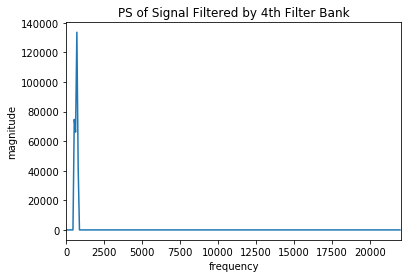

In [119]:
filtered_f = fbank*np.tile(f, (nfilt, 1))

plt.figure()
plt.plot(freq, filtered_f[3,:])
plt.title('PS of Signal Filtered by 4th Filter Bank')
ax = plt.axes()
ax.set_xlabel('frequency')
ax.set_ylabel('magnitude')
ax.set_xlim([0, 22050])

In [120]:
fbank_coefs = np.dot(fbank,f)
print fbank_coefs

[ 2914797.01716018  1597537.80079218   700419.69833245   316521.46870314
   625488.47139375    91069.88281031   111086.84836453   134491.58309571
    62539.07656345    63745.50818129    34571.24814318    56992.78716138
    38742.49989657    51363.64651115    50001.70737522    26471.24847627
    16122.10005486     6225.27937841     3986.19942855     4003.2560767 ]


### Question 3: what are the dimensions of fbank and f?

## D. Generating the MFCC's

The MFCC's are the [DCT](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.fftpack.dct.html) of the **log** of the filter bank coefficients. For the windowed input audio signal, the coefficients are computed below.

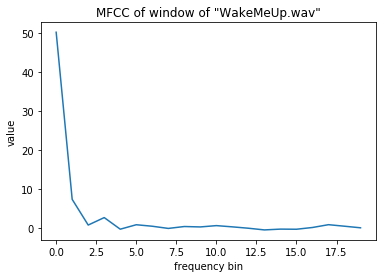

In [121]:
melMapped = np.log(fbank_coefs) # take the log of the mel-spaced mapping signal
mfcc = dct(melMapped.T, type = 2, axis = 0, norm = 'ortho')# take the Discrete Cosine Transform

plt.plot(mfcc)
plt.title('MFCC of window of "WakeMeUp.wav"')
ax = plt.axes()
ax.set_xlabel('frequency bin')
ax.set_ylabel('value')

Compare the coefficients of a window of 'WakeMeUp.wav' to a window of a different file, 'chopin.wav,' of a different genre of music with different frequency content.

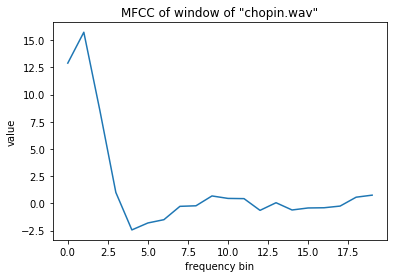

In [122]:
Fs2, x2 = wavfile.read('data/chopin.wav')     # x stores the input audio signal, Fs is the sampling frequency
signal2 = x2[:,0]

N=300
T = 10000
w2 = np.hamming(N)      # generate a Hamming window of length 300
s2 = signal2[T:T+NFFT]
f2 =  np.square((1.0/NFFT) *np.absolute(np.fft.rfft(s2,)))

fbank_coefs2 = np.dot(fbank,f2)

melMapped2 = np.log(fbank_coefs2) # take the log of the mel-spaced mapping signal
mfcc2 = dct(melMapped2.T, type = 2, axis = 0, norm = 'ortho')# take the Discrete Cosine Transform

plt.plot(mfcc2)
plt.title('MFCC of window of "chopin.wav"')
ax = plt.axes()
ax.set_xlabel('frequency bin')
ax.set_ylabel('value')

## Exercise 3

With the information and code examples provided above, you should now be able to implement a function to compute the MFCC of a given signal. (Hint, you will need the functions that you have defined so far, and other crucial code components are already provided above). You divide your signal into frames of length N, calculate the MFCC of that frame (which should give you 12 MFCC coefficients). The return variable of the function should have dimension of numberOfFrames by 12, where numberOfFrames is the number of frames in the signal **data**.

In [127]:
def calcMFCC(Fs, data, N, M):
    frames = (len(data) - N)/M
    mfcc = np.zeros((frames,20))
    highF = Fs/2
    lowF = 0
    highmel = hz2mel(highF)
    lowmel = hz2mel(lowF)
    NFFT = N
    nfilt = 20
    melPoints = np.linspace(lowmel, highmel, nfilt + 2)
    binPoints = np.floor(mel2hz(melPoints)/ Fs * (NFFT + 1))
    fbank = filterBank(nfilt, NFFT, binPoints)
    
    for i in range(frames):
        s = data[i * M : i * M + N]
        f =  np.square((1.0 / NFFT) * np.absolute(np.fft.rfft(s,)))
        fbank_coefs = np.dot(fbank, f)
        mel = np.log(fbank_coefs)
        mfcc[i] = dct(mel.T, axis = 0, norm = 'ortho')
    return mfcc

#### Hint: look at the file mfcclab.py to find the number of frames in a signal

# Speaker Identification

In this exercise, we will utilize the MFCC feature to recognize the identity of a speaker. You should put the two folders that were provided, train and test, into the same folder of your ipython notebook. There are 8 training data files and 8 testing data files, s1.wav to s8.wav. The training and testing data are already correctly labeled, i.e, s1.wav in the training folder matches with s1.wav in the testing folder (same person speaking). Nearest neighbor will be used to label the testing data.

Each audio file in this dataset is mono-channel, thus you do not need to split the files into two channels as in the previous part. However the files are of different length, which requires special attention to allocate the training dataset. For each audio file in the train folder, we create its MFCC matrix, where each row corresponds to 12 MFCC's of one frame. If your signal has 125 frames, for instance, the size of MFCC matrix will be 125 by 12. The MFCC matrix of all audio files are stacked into one matrix called the **codebook**. At the same time, we also store the labels of the training data. 

## Training

We first calculate the total number of frames of our whole dataset. This is used to initialize the codebook matrix and the label vector. Let's say you have only 2 audio files. The first file has 10 frames, and the second has 20 frames. Then the size of your **codebook** is 30 by 12. 

The length of your **labels** vector will be 30, in which the first 10 elements are *1* and the last 20 elements are *2*. For this exercise, we will choose the length of each frame to be 512 and the step size is one third of the frame length.

In [128]:
import mfcclab
# find the number of frames in advance
# this is to reduce dynamic array allocation 
# which slows down our code
N = 512
M = 512/3
sumNumFrames = mfcclab.get_num_frames("train", N, M) # total number of frames for all of the training data. 

We define the range of frequencies for our filter banks in Hertz, *lowfreq* and *highfreq* (from 0 Hz to the Nyquist rate). To create the endpoints for our filter banks, we transform this range into mel-scale range. The *for* loop loads all the training data in the **train** folder, computes the MFCC's, and appends them to the **codebook**. Since we know the labels of our data, this is considered an example of *supervised learning*, as opposed to an *unsupervised learning* paradigm, like K-means clustering, where the labels are unknown and must be learned.

In [129]:
highfreq = Fs/2 # Nyquist rate
lowfreq = 0 # lower end of audio spectrum

lowmel = hz2mel(lowfreq) # convert to Mel scales
highmel = hz2mel(highfreq)

NFFT = 512 # number of FFT points

nfilt = 20 # number of Mel spaced filter banks
# convert the frequency into Mel points
melPoints = np.linspace(lowmel, highmel, nfilt + 2)
binPoints = np.floor(mel2hz(melPoints)/Fs*(NFFT+1))

numKeptCoeff = 12 # we only keep the lower 12 coefficients since the higher frequencies 
# do not help speaker identification
fbank = filterBank(nfilt, NFFT, binPoints) # create the Mel-spaced filter bank
codeBook = np.empty((sumNumFrames, numKeptCoeff-1)) #preallocate the training data
labels = np.zeros((sumNumFrames,)) # and the labels
N = 512 # lenghth of a frame
M = 512/3 # step size
currentIdx = 0
for i in range(1,9): # we have 8 signals
    filename = "train/s%d.wav" % i # this is nhow you replace %d with i in Python 2. 
    fs, data = wavfile.read(filename)
    mfcc = calcMFCC(fs, data, N, M)[:,1:numKeptCoeff]
    codeBook[currentIdx:currentIdx + mfcc.shape[0],:] = mfcc# assign this training data to codebook
    labels[currentIdx:currentIdx + mfcc.shape[0]] = i # and label them
    currentIdx = currentIdx + mfcc.shape[0] # move to next block in codeBook and labels

Since the each codeword in the codebook is of dimension 11, it is not possible to visualize the distribution of the codewords and their proximity to each other. However, tools exist that attempt to reduce the dimensionality of data while preserving the relative distances between data points. The following code uses a tool called Isomap (a non-linear dimension-reduction technique, unlike PCA) to plot the data in 2D to give some intuition of the distribution of the codewords. How well grouped are the codewords for each speaker?

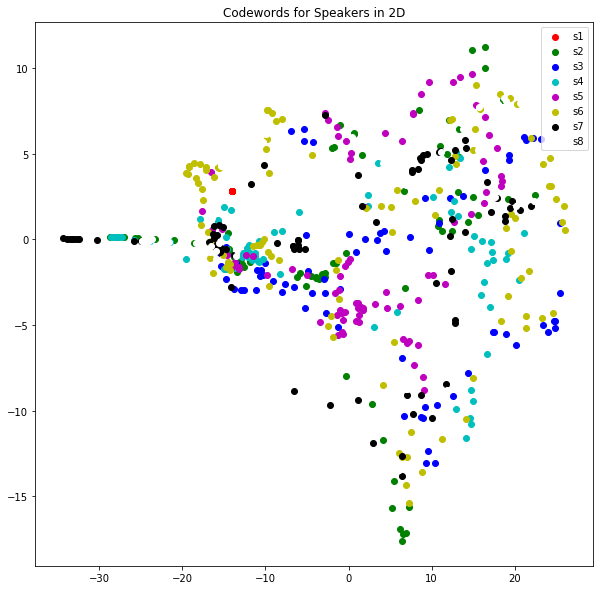

In [130]:
mfcclab.plot_codebook_2D(codeBook, labels, ["s1", "s2", "s3", "s4", "s5", "s6", "s7", "s8"])

### Exercise 4

Use your favourite classifier from part I of the course to train and test on the given data. What is the accuracy of your classifier?

In [136]:
from sklearn import neighbors
NN = neighbors.KNeighborsClassifier(n_neighbors = 4)
NN.fit(codeBook, labels)
print "Accuracy of fit: " + str(NN.score(codeBook, labels))

Accuracy of fit: 0.86943620178


### Exercise 5 - Extra Credit

The current algorithm will predict a speaker regardless if it is in the database. Propose and implement a modification that will be able to do so. Record a short clip of your own voice and briefly describe and comment on your results and observations.

In [92]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In last week's lab you were asked to propose a method to find where is the sky in a picture. A more general version of this task is called image segmentation, where we attempt to split an image into regions that are the same 'thing'. In this lab, we will attempt to implement a simple model.

# How do we define a segment?

We can work with a simplistic model that the same 'thing' will have similar color. If we make this assumption, we can make use of clustering algorithms to attempt segmentation.

### Exercise 6

1. Give 1 potential pitfall when using such a simplistic assumption

**This approach would require the use of a mean, and since we are looking at frequency peaks, relying on a mean would result in a loss data.**

# Segmentation using K-Means

As we have learnt from the previous lab, an image is merely a collection of RGB values. We can ignore the spatial arrangement of every pixel, and treat each one of them as a 3-dimensional vector. Pixels with similar RGB values will be close to each other in a 3 dimensional space.

This will allow us to formulate the segmentation problem as follows:
1. Decide on the number of segments,$k$, in the image
2. Reshape the image into a $(w*h) \times 3$ vector, where each row is a pixel's RGB values
3. Run the K-Means algorithm using this as the training data. 

To visualize the clustering, you might want to replace all pixels in the cluster with a single color. 

In [94]:
from sklearn.cluster import KMeans

### Exercise 7

1. Implement the algorithm described above
2. Try a different number of clusters (3, 10, 20)

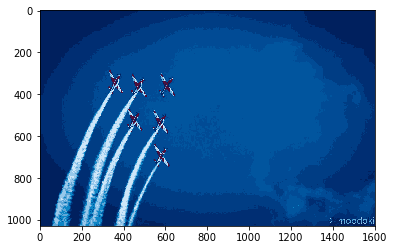

In [99]:
clusters = 10
img = np.array(Image.open('data/roulettes.jpg'))
newImg = np.reshape(img,(1029 * 1600, 3))
KM = KMeans(n_clusters = clusters)
labels = KM.fit_predict(newImg)
center = KM.cluster_centers_

for k in range(clusters):
    for i in range(len(labels)):
        if labels[i] == k:
            newImg[i] = center[k]
            
retImg = np.reshape(newImg,(1029, 1600, 3))
plt.imshow(retImg)
plt.show()

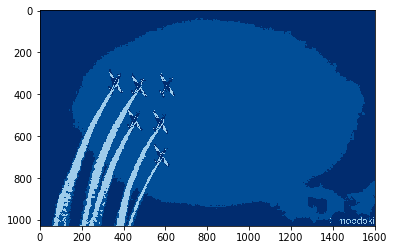

In [98]:
clusters = 3
img = np.array(Image.open('data/roulettes.jpg'))
newImg = np.reshape(img,(1029 * 1600, 3))
KM = KMeans(n_clusters = clusters)
labels = KM.fit_predict(newImg)
center = KM.cluster_centers_
for k in range(clusters):
    for i in range(len(labels)):
        if labels[i] == k:
            newImg[i] = center[k]
retImg = np.reshape(newImg,(1029, 1600, 3))
plt.imshow(retImg)
plt.show()